# Lab 1 - ARIMA+NN

1. (2 points) Apply ARIMA model for forecasting. Explain the choice of p,d,q paramters. Did you
notice anything strange?
2. (3 points) Implement LSTM architectures for the given dataset. Estimate its performance.
3. (3 points) Implement TSS architectures for the given dataset. Estimate its performance.
4. (2 points) Compare results of the algorithms.

In [1]:
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin

In [2]:
train = np.load(join("data", "train.npy"))
test = np.load(join("data", "test.npy"))

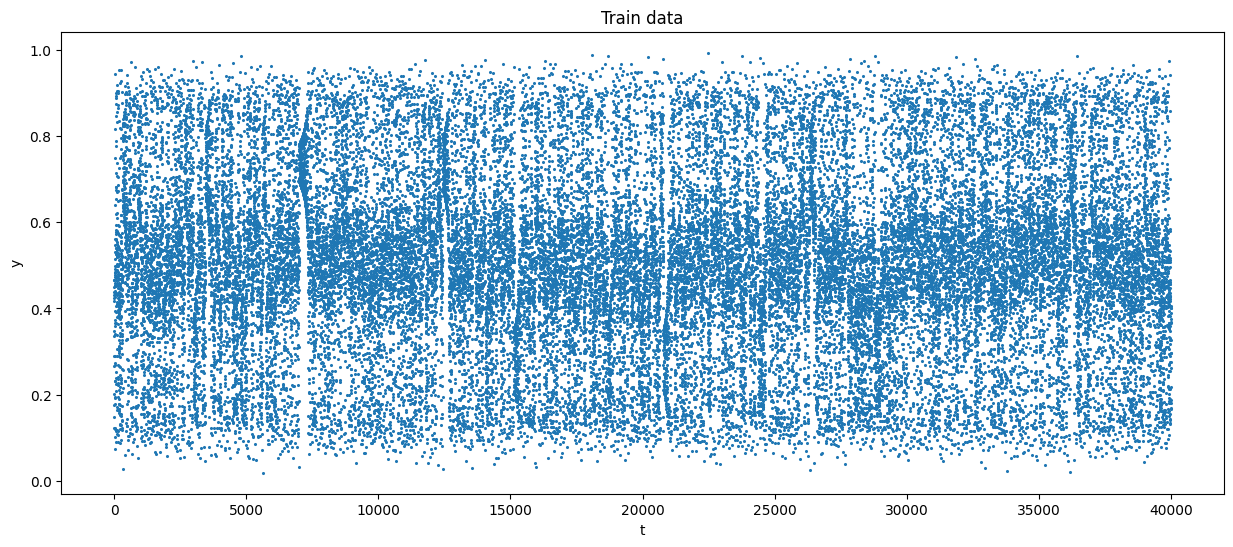

In [3]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(40_000), train, s=1.5)
plt.title("Train data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

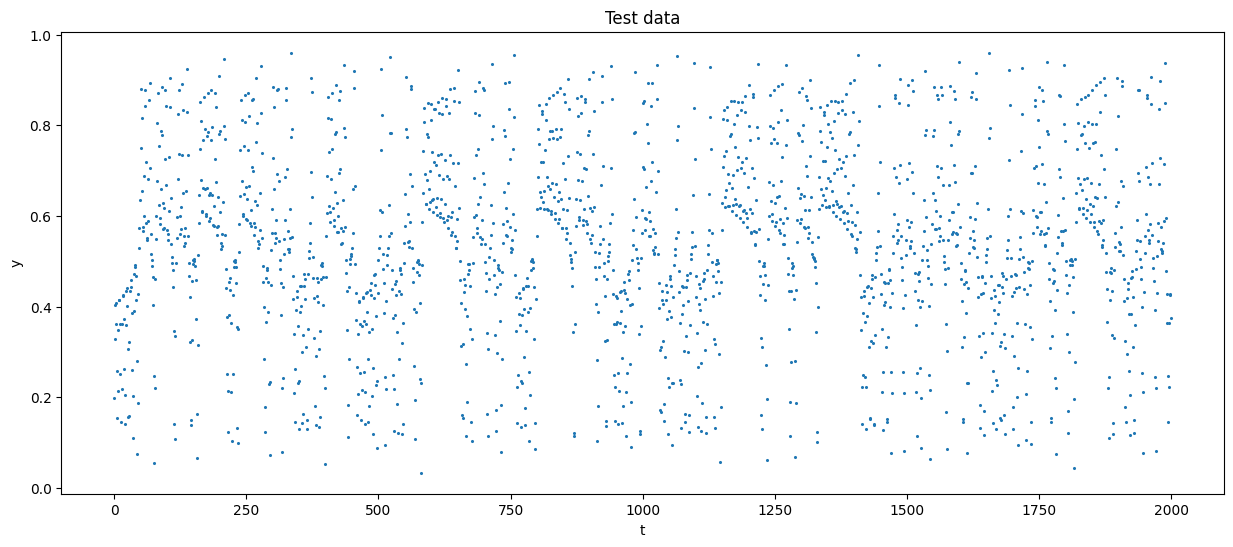

In [4]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(2_000), test, s=1.5)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

In [5]:
def acf(series: np.ndarray, k: int) -> float:
    mean = np.mean(series)
    return ((series[k:] - mean) * (series[:-k] - mean)).sum() / np.power(series - mean, 2).sum()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 925.74it/s]


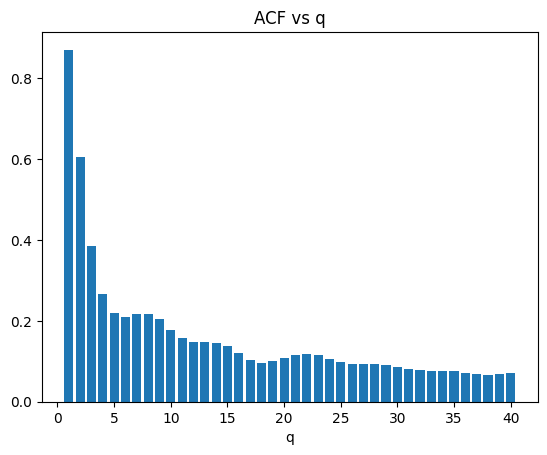

In [6]:
from tqdm import trange

k = 40

acf_data = [acf(train, i) for i in trange(1, k+1)]
plt.bar(np.arange(1, k + 1), acf_data[:k])
plt.title("ACF vs q")
plt.xlabel("q")
plt.show()

According to the graph `q` should be equal to 3

In [7]:
def get_batched_data(data, batch_size):
    split_idx = [i * batch_size for i in range(batch_size, data.shape[0] // batch_size)]
    if data.shape[0] % batch_size:
        split_idx = split_idx[:-1]
    return np.split(data, split_idx)

In [8]:
from numpy.lib.stride_tricks import sliding_window_view

class AR(BaseEstimator, RegressorMixin):
    def __init__(self, p: int, lr: float = 1e-1, max_iter: int = 100, tol: float = 1e-7, batch_size: int = 32):
        self.weights_ = np.random.normal(size=(p,))
        self.bias_ = np.random.normal()
        self.order = (p,)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.batch_size_ = batch_size
        if self.batch_size_ < self.order[0]:
            raise ValueError(f"Batch size {batch_size} smaller than order {p}")

    def fit(self, X):
        p = self.order[0]
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}. "
        self.loss_hist_ = []
        X_batched = get_batched_data(X, self.batch_size_)
        for i in range(self.max_iter_):
            for x_batch in X_batched:
                resid = x_batch[p:] - sliding_window_view(x_batch[:-1], p) @ self.weights_ - self.bias_
                self.bias_ += self.lr_ * resid.mean()
                self.weights_ += self.lr_ * (resid @ sliding_window_view(x_batch[:-1], p)) / resid.shape[0]
                loss = (resid**2).mean()
                self.loss_hist_.append(loss)
                if i != 0:
                    if np.abs(loss - prev_loss) < self.tol_:
                        self.convergence_message = "Successfully converged. "
                        break
                prev_loss = loss
        self.convergence_message += f"Loss: {loss:0.4f}"
        return self

    def predict(self, X):
        p = self.order[0]
        return X[-p:] @ self.weights_ + self.bias_

Successfully converged. Loss: 0.0043


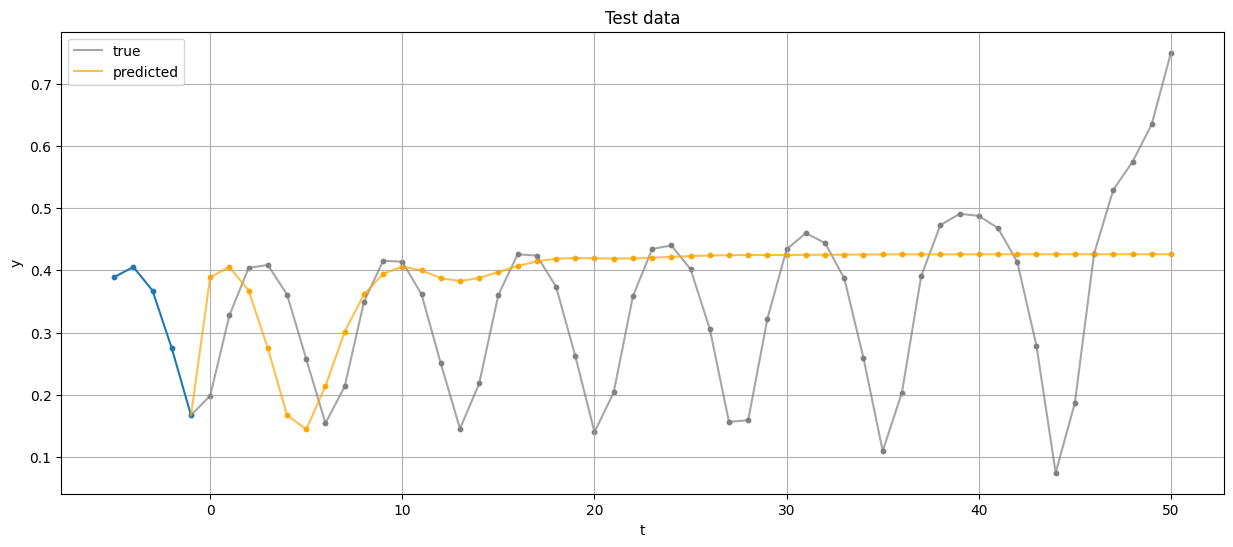

In [9]:
k = 50
p = 5

ar = AR(p).fit(train)
ar_preds = train[-p:]
print(ar.convergence_message)

for i in range(0, k + 1):
    pred = ar.predict(ar_preds)
    ar_preds = np.append(ar_preds, pred)

# ar_preds = np.array([ar.predict(train[:i + p]) for i in range(0, k - p + 1)])

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(-p, 0), train[-p:], s=10)
plt.plot(np.arange(-p, 0), train[-p:])
plt.scatter(np.arange(0, k+1), test[:k+1], s=10, c="grey")
plt.plot(np.arange(0, k+1), test[:k+1], c="grey", alpha=.7, label = "true")
plt.plot([-1, 0], [train[-1], test[0]], c="grey", alpha=.7)
plt.scatter(np.arange(0, k+1), ar_preds[:k+1], s=10, c="orange")
plt.plot(np.arange(0, k+1), ar_preds[:k+1], c="orange", alpha=.7, label="predicted")
plt.plot([-1, 0], [train[-1], ar_preds[0]], c="orange", alpha=.7)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

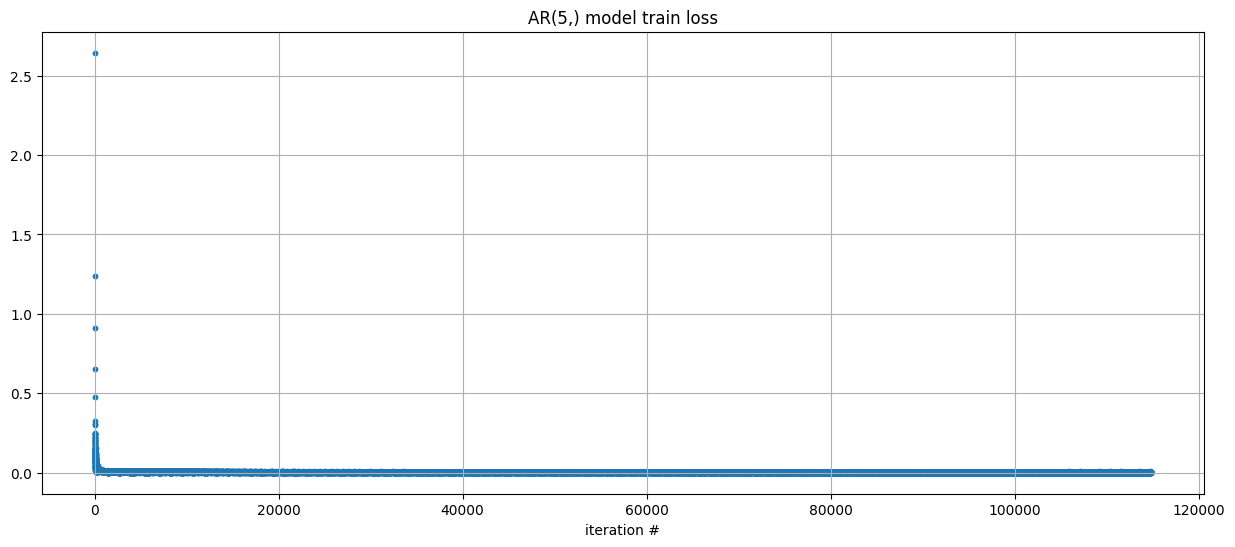

In [10]:
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(0, len(ar.loss_hist_)), ar.loss_hist_, s=10)
plt.title(f"AR{ar.order} model train loss")
plt.xlabel("iteration #")
plt.grid()
plt.show()

In [11]:
def pacf(series: np.ndarray, p: int) -> float:
    linreg = AR(p).fit(series)
    return linreg.weights_[0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.65s/it]


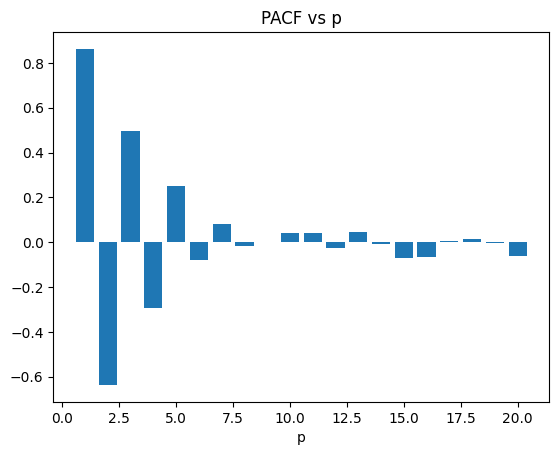

In [12]:
from tqdm import trange

k = 20
pacf_data = [pacf(train, i) for i in trange(1, k+1)]

plt.bar(np.arange(1, k+1), pacf_data[:k])
plt.title("PACF vs p")
plt.xlabel("p")
plt.show()

The PACF plot suggests that `p` should be equal to 5, since it experiences a sharp breakoff

In [26]:
import warnings

from tqdm import tqdm

warnings.filterwarnings("error")

class ARMA(BaseEstimator, RegressorMixin):
    def __init__(self, p: int, q: int, lr: float = 1e-1, max_iter: int = 100, tol: float = 1e-7, batch_size: int = 32):
        self.weights_ = np.random.normal(size=(p,))
        self.residual_weights_ = np.random.normal(size=(q,))
        self.bias_ = np.random.normal()
        self.order = (p, q)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol
        self.batch_size_ = batch_size
        if self.batch_size_ < max(self.order):
            raise ValueError(f"Batch size {batch_size} too small for order {self.order}")

    def AR_iter(self, x_batch) -> None:
        p, _ = self.order
        resid = x_batch[p:] - sliding_window_view(x_batch[:-1], p) @ self.weights_
        self.weights_ += self.lr_ * (resid @ sliding_window_view(x_batch[:-1], p)) / resid.shape[0]
        return None

    def MA_iter(self, res_batch) -> None:
        _, q = self.order
        resid = res_batch[q:] - sliding_window_view(res_batch[:-1], q) @ self.residual_weights_ - self.bias_
        self.residual_weights_ += self.lr_ * (resid @ sliding_window_view(res_batch[:-1], q)) / resid.shape[0]
        self.bias_ += self.lr_ * resid.mean()
        return None

    def fit(self, X):
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}. "
        self.loss_hist_ = []
        p, q = self.order
        for i in range(self.max_iter_):
            for bid, x_batch in enumerate(get_batched_data(X, self.batch_size_)):
                if x_batch.shape[0] > max(self.order):
                    self.AR_iter(x_batch)
        resid_ar = x_batch[p:] - sliding_window_view(x_batch[:-1], p) @ self.weights_
        resid_ar = np.concatenate((np.random.normal(size=p), resid_ar))

        for i in range(self.max_iter_):
            for bid, res_batch in enumerate(get_batched_data(resid_ar, self.batch_size_)):
                    self.MA_iter(res_batch)
                    resid_arma = res_batch[q:] - sliding_window_view(res_batch[:-1], q) @ self.residual_weights_ - self.bias_
                    try:
                        loss = (resid_arma**2).mean()
                    except:
                        print(f"Epoch #{i}. Batch #{bid}")
                        print(resid_ar[-10:])
                        print(resid_arma[-10:])
                        break
                    self.loss_hist_.append(loss)
                    if i != 0:
                        if np.abs(loss - prev_loss) < self.tol_:
                            self.convergence_message = "Successfully converged. "
                            break
                    prev_loss = loss

            else:
                continue
            break
        self.residuals = resid_ar[-q:]
        self.data = X[-p:]
        self.convergence_message += f"Loss: {loss:0.4f}"
        return self

    def predict(self, n_steps):  
        p, q = self.order
        if len(self.data) - p < n_steps:  
            ans = np.zeros(n_steps - p)
            for i in range(n_steps - p):
                ans[i] = self.data[-p:] @ self.weights_ + self.residuals[-q:] @ self.residual_weights_+ self.bias_
                self.data = np.concatenate((self.data, [ans[i]]))
                res = ans[i] - self.data[-p:] @ self.weights_
                self.residuals = np.concatenate((self.residuals, [res]))
        
        return self.data[p:p+n_steps]

In [34]:
class ARIMA(BaseEstimator, RegressorMixin):
    def __init__(self, p: int, q: int, d: int, lr: float = 1e-1, max_iter: int = 100, tol: float = 1e-7, verbose: bool = False):
        super().__init__()
        self.arma_model_ = ARMA(p, q)
        self.order = (p, q, d)
        self.lr_ = lr
        self.max_iter_ = max_iter
        self.tol_ = tol

    def get_diffs(self, X, d):
        for _ in range(d):
            X = np.diff(X)
        return X

    def get_inverse_diffs(self, y_base, diff_pred, d):
        result = np.array(diff_pred, dtype=float)
        for _ in range(d):
            result = np.r_[y_base[-1], result].cumsum()
            last_values = result
        return result[d:]

    def fit(self, X):
        self.convergence_message = f"Terminated after max_iter={self.max_iter_}. "
        loss_hist = []
        p, q, d = self.order

        X_diffs = self.get_diffs(X, d)

        self.arma_model_ = self.arma_model_.fit(X_diffs)
        self.convergence_message = self.arma_model_.convergence_message
        return self

    def predict(self, n_steps):
        p, q, d = self.order
        diff_pred = self.arma_model_.predict(n_steps)
        return self.get_inverse_diffs(self.arma_model_.data, diff_pred, d)

Terminated after max_iter=100. Loss: 0.0250


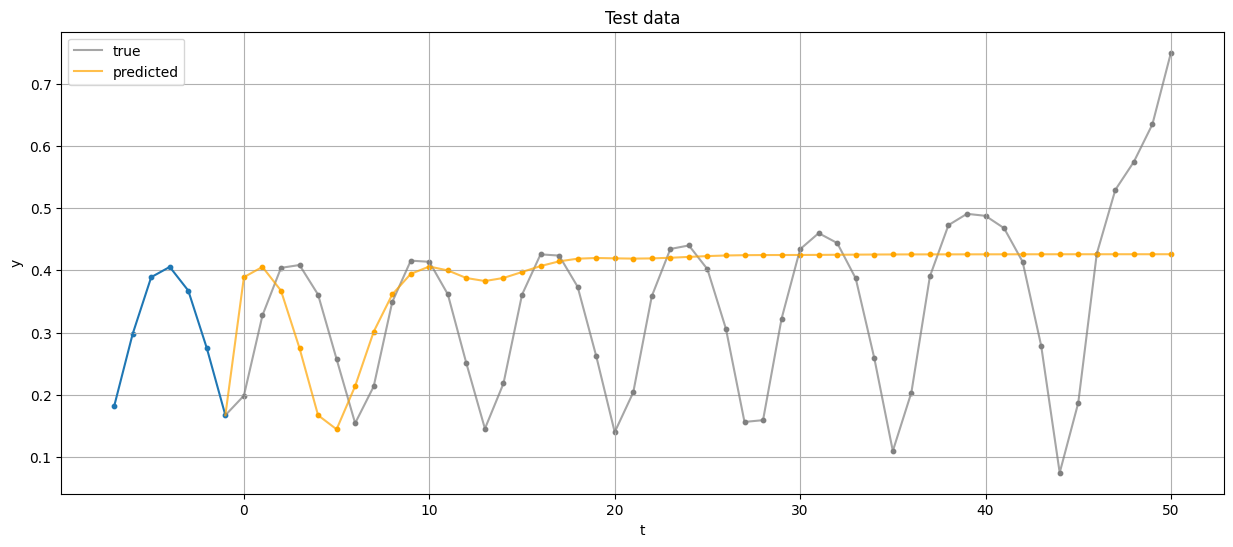

In [38]:
k = 50
p = 5
q = 3
d = 2
window_size = max(p+d, q+d)

arima = ARIMA(p, q, d).fit(train)
arima_preds = arima.predict(k)
print(arima.convergence_message)

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(-window_size, 0), train[-window_size:], s=10)
plt.plot(np.arange(-window_size, 0), train[-window_size:])
plt.scatter(np.arange(0, k+1), test[:k+1], s=10, c="grey")
plt.plot(np.arange(0, k+1), test[:k+1], c="grey", alpha=.7, label = "true")
plt.plot([-1, 0], [train[-1], test[0]], c="grey", alpha=.7)
plt.scatter(np.arange(0, k+1), ar_preds[:k+1], s=10, c="orange")
plt.plot(np.arange(0, k+1), ar_preds[:k+1], c="orange", alpha=.7, label="predicted")
plt.plot([-1, 0], [train[-1], ar_preds[0]], c="orange", alpha=.7)
plt.title("Test data")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()

In [2]:
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

class LSTM(nn.Module):
    def __init__(self, lookback: int = 16, hid_dim: int = 64):
        super().__init__()
        self.hid_dim = hid_dim
        self.forget_gate = nn.Sequential(nn.Linear(lookback+hid_dim, hid_dim), nn.Sigmoid())
        self.input_gate = nn.Sequential(nn.Linear(lookback+hid_dim, hid_dim), nn.Sigmoid())
        self.input_node = nn.Sequential(nn.Linear(lookback+hid_dim, hid_dim), nn.Tanh())
        self.output_gate = nn.Sequential(nn.Linear(lookback+hid_dim, hid_dim), nn.Sigmoid())

    def forward(self, X, H_C=None):
        if hid_state is None:
            hid_state = torch.randn(X.shape[0], self.hid_dim, requires_grad=True)
            int_state = torch.randn(X.shape[0], self.hid_dim, requires_grad=True)
        else:
            hid_state, int_state = H_C

        ans = []
        for inp in X: 
            x_h = torch.cat((inp.reshape(1, -1), hid_state), -1)
            
            forget_val = self.forget_gate(x_h)
            input_val = self.input_gate(x_h) * self.input_node(x_h)
            output_val = self.output_gate(x_h)
            int_state *= forget_val
            int_state += input_val
            hid_state = output_val * F.tanh(int_state)
            ans.append(hid_state)

        ans = torch.tensor(ans, device=device)
            
        return ans, (hid_state, int_state)


NameError: name 'torch' is not defined

In [ ]:
class MyNetwork(nn.Module):
    def __init__(self, lookback: int = 16, hid_size: int = 64, out_size: int = 1):
        super().__init__()
        self.lstm1 = LSTM(lookback = lookback)
        self.lstm2 = LSTM(lookback = lookback)
        self.lstm3 = LSTM(lookback = lookback)
        self.lstm4 = LSTM(lookback = lookback)
        self.out = nn.Sequential()
        self.h_c = (torch.rand(hid_size), torch.randn(hid_size))

    def forward(self, X):
        self.h_c = self.lstm1(X, self.h_c)
        self.h_c = self.lstm2(X, self.h_c)
        self.h_c = self.lstm3(X, self.h_c)
        h, _ = self.lstm4(X, self.h_c)
        return h